In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
import xarray as xr 

from include.neural_net import NeuralNet

In [285]:
weathermob_data = torch.from_numpy(pd.read_csv("../../data/Covid_mob/Berlin_data/weather_mobility.csv", index_col=0).to_numpy(dtype=float)).float().reshape(-1, 2, 1)
weathermob_df = pd.read_csv("../../data/Covid_mob/Berlin_data/weather_mobility.csv", index_col=0)
weathermob_df.index = pd.to_datetime(weathermob_df.index)

data = pd.read_csv("../../data/Covid_raw/Berlin_data/data_short.csv", index_col=0, parse_dates=True)

# Preprocess the data
# Combine exposed and infected into a single 'infected' variable
#data['infected'] = data['exposed']

# Combine recovered and deceased into a single 'recovered' variable
data['recovered'] = data['recovered'] + data['deceased']

# Drop unnecessary columns
data = data[['susceptible', 'infected', 'recovered']]

# Normalize the data
data[['susceptible', 'infected', 'recovered']] = data[['susceptible', 'infected', 'recovered']].astype(float)

In [286]:
data.columns

Index(['susceptible', 'infected', 'recovered'], dtype='object')

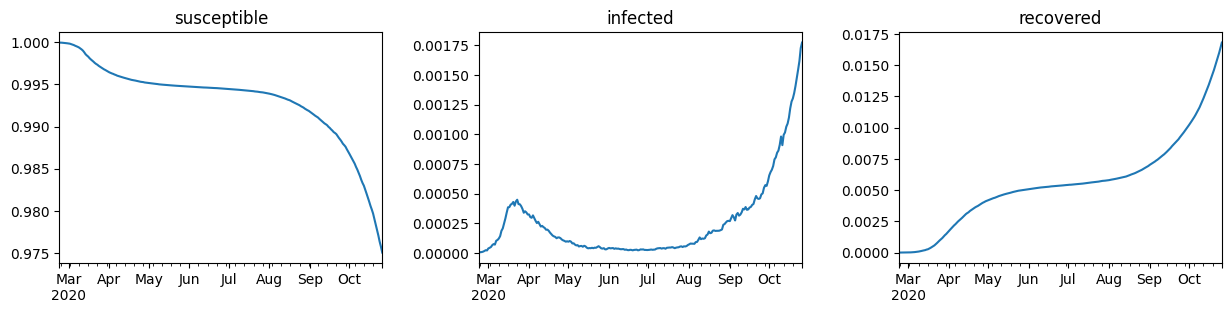

In [287]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 3), gridspec_kw=dict(wspace=0.3))
for idx, col in enumerate(data.columns):
    data[col].plot(ax=axs[idx], title=col)

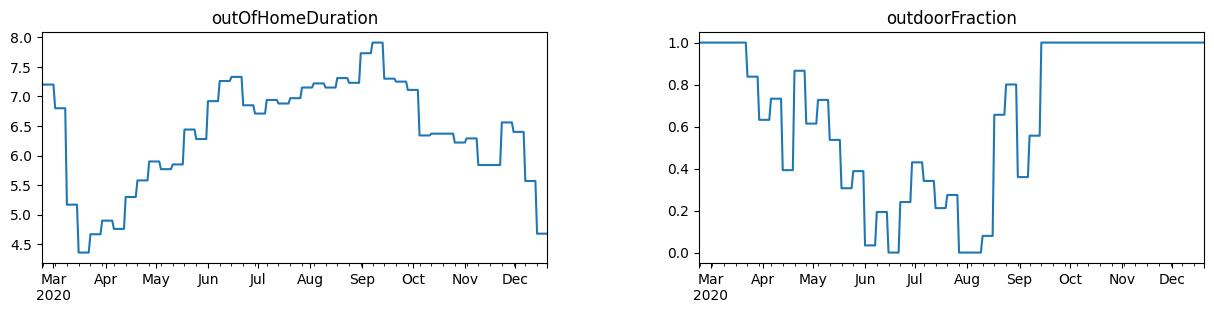

In [288]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 3), gridspec_kw=dict(wspace=0.3))
for idx, col in enumerate(weathermob_df.columns):
    weathermob_df[col].plot(ax=axs[idx], title=col)

In [289]:
# Split into a training and test/prediction set
training_data, test_data = torch.from_numpy(data.values).float()[:233], torch.from_numpy(data.values).float()[233:]
alpha = training_data.sum(dim=0)**(-1)
training_data.shape, test_data.shape, alpha.shape

(torch.Size([233, 3]), torch.Size([14, 3]), torch.Size([3]))

In [106]:
for idx in [0, 2]:  # E, R, Sy, H, C, qS, qE, qI are dropped
    alpha[idx] = 0
alpha

tensor([ 0.0000, 22.1780,  0.0000])

In [290]:
# Define a simple SIR model
def SIR_model(state: torch.Tensor, parameters: dict) -> torch.Tensor:
    new_state = state + torch.stack([- parameters['k_I'] * state[0] * state[1], 
                                      + parameters['k_I'] * state[0] * state[1] - parameters['k_R'] * state[1],
                                      + parameters['k_R'] * state[1]
                                ]) * parameters['dt']
    return new_state

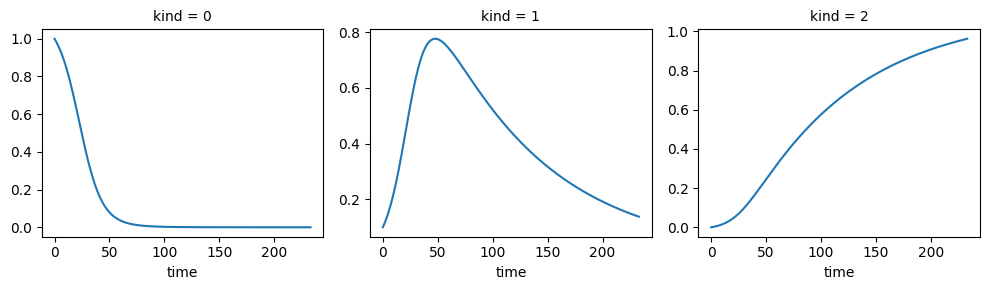

In [291]:
# Small example of the SIR model 
data = [training_data[0] + torch.tensor([0, 0.1, 0])]
for n in range(training_data.shape[0]):
    data.append(SIR_model(data[-1], parameters=dict(k_I=1, k_R=0.1, dt=0.1)))
xr.DataArray(data, dims=["time", "kind"]).plot(col="kind", sharey=False)

In [416]:
# Initialise the neural network
NN = NeuralNet(
    input_size=training_data.shape[1],
    output_size=4, #learn twoo! parameters
    num_layers=5,
    nodes_per_layer=dict(default=20),
    activation_funcs=dict(default='sigmoid', layer_specific={0: 'softplus', -1: 'softplus'}),
    biases=dict(default=[-1, 1]),
    learning_rate=0.001
)

loss_ts = []

In [417]:
pred_param = []

In [418]:
# Train
n_epochs = 200
batch_size = 10
write_every = 10
parameters = dict(dt=1)

for e in (pbar := tqdm.tqdm(range(n_epochs))):
    
    # Run the model, stopping to update the estimates every n steps
    predicted_data = [training_data[0].clone()]
    start_idx = 0
    epoch_loss = []
    _pred_param = []
    
    for t in range(training_data.shape[0]):
        
        predicted_parameters = NN(training_data[t])
        if e % write_every == 0:
            _pred_param.append(predicted_parameters.clone().detach())
        
        #if t < 30:
        beta = torch.clamp((predicted_parameters[0]*weathermob_data[t, 0]**predicted_parameters[3] - (predicted_parameters[1]*weathermob_data[t, 0]**predicted_parameters[3])*(weathermob_data[t, 1]+1)), min=0.001)

        predicted_data.append(SIR_model(predicted_data[-1], 
                                        parameters={'k_I': beta[0],
                                                    'k_R': predicted_parameters[2], 
                                                    'dt': torch.tensor(1)}))

        if t > 0 and (len(predicted_data) % batch_size == 0):
            
            loss = (
                alpha * ((torch.stack(predicted_data)[1:, :] - training_data[start_idx+1:start_idx+len(predicted_data), :])**2).sum(dim=0)
            ).sum(dim=0)
            loss.backward()
            NN.optimizer.step()
            NN.optimizer.zero_grad()
            start_idx = t
            epoch_loss.append(loss.detach())
            if t < training_data.shape[0] - 1:
                predicted_data = [training_data[t+1].clone()]
    if e % write_every == 0:
        pred_param.append(_pred_param)
    loss_ts.append(np.mean(epoch_loss))
    pbar.set_description(f"Loss: {loss_ts[-1]}")

Loss: 1.5637593605788425e-05: 100%|██████████| 200/200 [01:09<00:00,  2.89it/s]


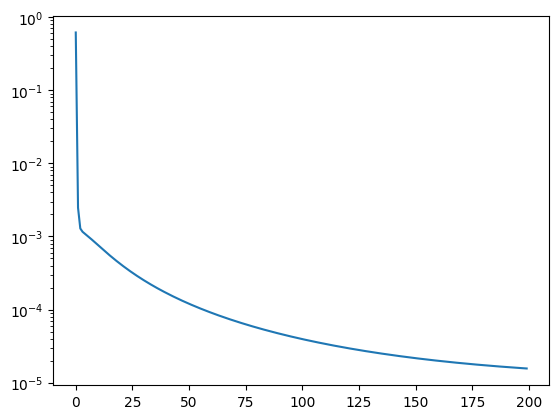

In [419]:
fig, ax = plt.subplots()
ax.plot(loss_ts)
ax.set_yscale('log')

In [420]:
preds = torch.stack([torch.stack(x) for x in pred_param])
preds.shape

torch.Size([20, 233, 4])

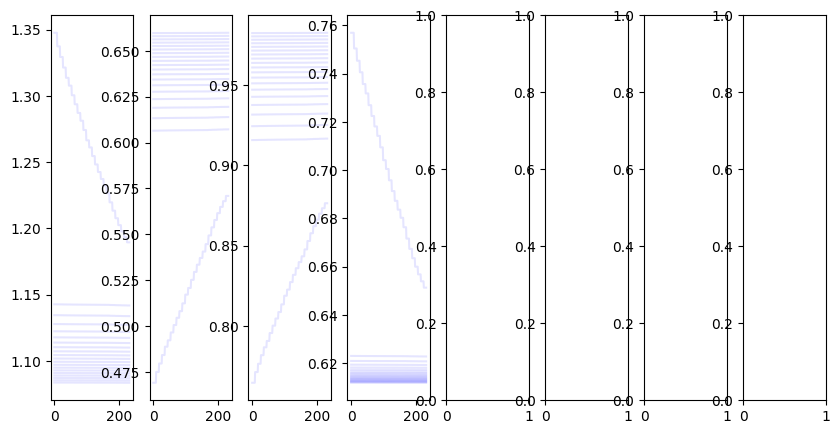

In [421]:
fig, axs = plt.subplots(ncols=8, figsize=(10, 5))
for p in preds:
    for idx, arr in enumerate(p.transpose(0, 1)):
        axs[idx].plot(arr, alpha=0.1, color='blue')

In [422]:
[training_data[0]]

[tensor([9.9998e-01, 3.3570e-06, 2.2380e-06])]

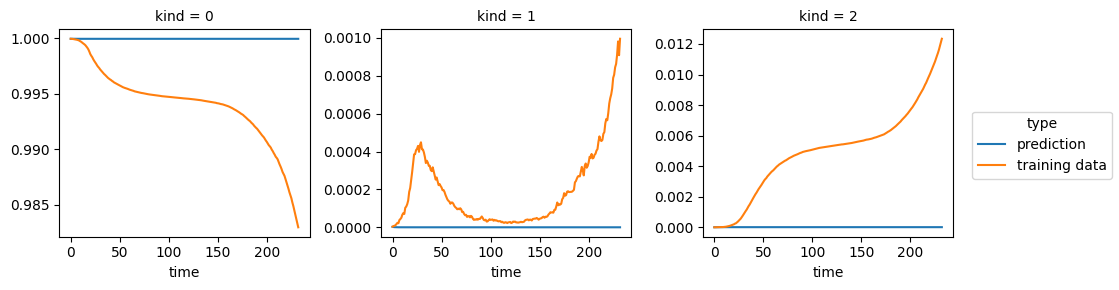

In [423]:
predicted_data = [training_data[0]]
for t in range(training_data.shape[0]):
    
    predicted_parameters = NN(training_data[t]).detach()
    #if t < 100:
    beta = torch.clamp((
            predicted_parameters[0]*weathermob_data[t, 0]**predicted_parameters[3] - (predicted_parameters[1]*weathermob_data[t, 0]**predicted_parameters[3])*(weathermob_data[t, 1]+1))
        ,0.6)
    # else: 
    #     beta = torch.clamp((
    #             predicted_parameters[4]*weathermob_data[t, 0]**predicted_parameters[6] - (predicted_parameters[5]*weathermob_data[t, 0]**predicted_parameters[6])*weathermob_data[t, 1]),
    #         0.001)
    #beta = predicted_parameters[0] + weathermob_data[t, 0]*predicted_parameters[1]
    predicted_data.append(SIR_model(predicted_data[t], 
                                    parameters={'k_I': beta[0], 
                                                'k_R': predicted_parameters[2], 'dt': torch.tensor(1)}))
xr.concat([
    xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}), 
    xr.DataArray(training_data, dims=["time", "kind"]).expand_dims({'type': ['training data']})], dim='type').plot(col="kind", hue='type', sharey=False)

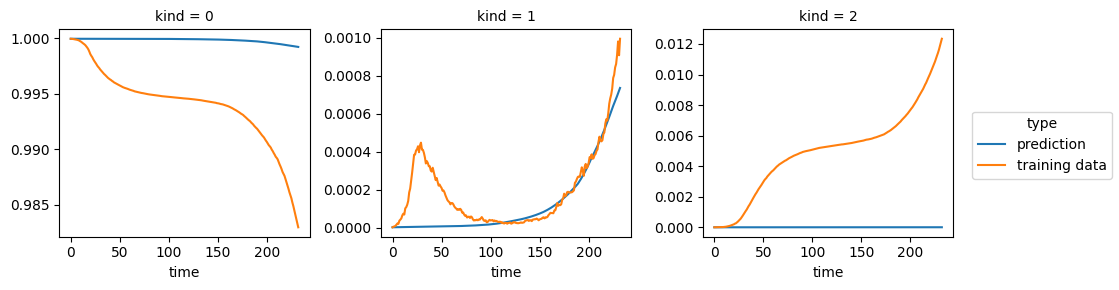

In [215]:
predicted_data = [training_data[0]]
for t in range(training_data.shape[0]):
    
    predicted_parameters = NN(training_data[t]).detach()
    # beta = torch.sigmoid((predicted_parameters[0]*weathermob_data[t, 0]**2) - (predicted_parameters[1]*weathermob_data[t, 0]**2)*weathermob_data[t, 1])
    beta = 0.15*(0.04*(weathermob_data[t, 0]**2) - 0.007*weathermob_data[t, 1]*(weathermob_data[t, 0])**2)
    predicted_data.append(SIR_model(predicted_data[t], 
                                    parameters={'k_I': beta[0], 
                                                'k_R': 0.001, 'dt': torch.tensor(0.1)}))
xr.concat([
    xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}), 
    xr.DataArray(training_data, dims=["time", "kind"]).expand_dims({'type': ['training data']})], dim='type').plot(col="kind", hue='type', sharey=False)

In [204]:
for t in range(training_data.shape[0]):
    beta = 0.024*weathermob_data[t,0]**2 - (0.005*weathermob_data[t,1]*weathermob_data[t, 0]**2)
    print(beta)

tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([7.3379])

In [67]:
NN(training_data[t])

tensor([4.8106e-03, 7.8599e-05, 2.7032e+00], grad_fn=<SoftplusBackward0>)

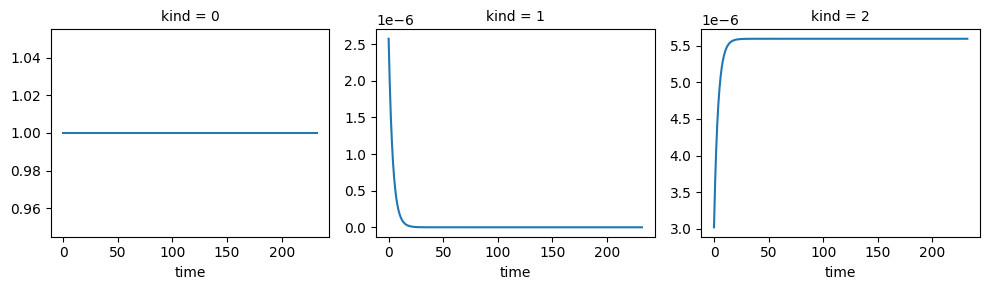

In [247]:
xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}).plot(col="kind", sharey=False)

In [56]:
len(predicted_data)

210

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Create a toy DataFrame with weather and mobility data
data = {
    'time': np.arange(0, 50, 1),  # Time points
    'weather': np.random.uniform(0.1, 0.9, 50),  # Random weather data (e.g., fraction of good weather)
    'mobility': np.random.uniform(0.5, 1.5, 50)  # Random mobility data (e.g., time spent out of home)
}

df = pd.DataFrame(data)
print(df.head())


   time   weather  mobility
0     0  0.758853  0.664688
1     1  0.289212  0.525703
2     2  0.236241  0.745787
3     3  0.754888  1.146519
4     4  0.864464  1.223223


0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.5974207999999999
0.5974207999999999
0.5974207999

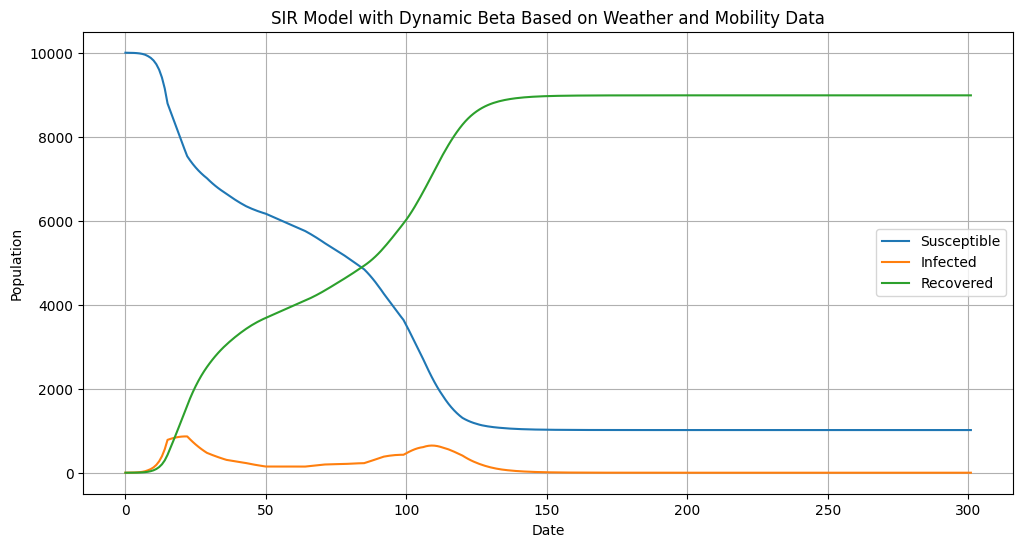

In [363]:
# Define parameters for beta calculation
par1 = 0.0024  # Parameter 1 for beta calculation (adjustable)
par2 = 0.0005  # Parameter 2 for beta calculation (adjustable)

# Total population, N
N = 10000
# Initial number of infected and recovered individuals, I0 and R0
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Function to calculate beta based on outOfHomeDuration and outdoorFraction
def calculate_beta(out_of_home_duration, outdoor_fraction, par1, par2):
    # Calculate beta using given parameters and formula
    beta = par1 * out_of_home_duration**3- par2 * outdoor_fraction * out_of_home_duration**3
    return max(beta, 0.001)  # Apply a minimum constraint to avoid negative or zero values

# The SIR model differential equations
def sir_model(y, t, N, par1, par2, df):
    S, I, R = y
    # Find the closest matching index for the current time 't'
    current_index = int(min(t, len(df) - 1))
    current_data = df.iloc[current_index]
    # Calculate beta using current values of outOfHomeDuration and outdoorFraction
    beta = calculate_beta(current_data['outOfHomeDuration'], current_data['outdoorFraction'], par1, par2)
    print(beta)
    gamma = 0.2  # Recovery rate, assumed constant

    # SIR model equations
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Time grid corresponding to the length of the data
t = np.arange(len(weathermob_df))

# Integrate the SIR equations over the time grid, t
result = odeint(sir_model, y0, t, args=(N, par1, par2, weathermob_df))

# Extract the results
S, I, R = result.T

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('SIR Model with Dynamic Beta Based on Weather and Mobility Data')
plt.legend()
plt.grid()
plt.show()


tensor(0.7092)
tensor(0.7092)
tensor(0.7092)
tensor(0.7092)
tensor(0.7092)
tensor(0.7092)
tensor(0.7092)
tensor(0.7092)
tensor(0.5974)
tensor(0.5974)
tensor(0.5974)
tensor(0.5974)
tensor(0.5974)
tensor(0.5974)
tensor(0.5974)
tensor(0.2626)
tensor(0.2626)
tensor(0.2626)
tensor(0.2626)
tensor(0.2626)
tensor(0.2626)
tensor(0.2626)
tensor(0.1575)
tensor(0.1575)
tensor(0.1575)
tensor(0.1575)
tensor(0.1575)
tensor(0.1575)
tensor(0.1575)
tensor(0.2018)
tensor(0.2018)
tensor(0.2018)
tensor(0.2018)
tensor(0.2018)
tensor(0.2018)
tensor(0.2018)
tensor(0.2452)
tensor(0.2452)
tensor(0.2452)
tensor(0.2452)
tensor(0.2452)
tensor(0.2452)
tensor(0.2452)
tensor(0.2193)
tensor(0.2193)
tensor(0.2193)
tensor(0.2193)
tensor(0.2193)
tensor(0.2193)
tensor(0.2193)
tensor(0.3281)
tensor(0.3281)
tensor(0.3281)
tensor(0.3281)
tensor(0.3281)
tensor(0.3281)
tensor(0.3281)
tensor(0.3418)
tensor(0.3418)
tensor(0.3418)
tensor(0.3418)
tensor(0.3418)
tensor(0.3418)
tensor(0.3418)
tensor(0.4298)
tensor(0.4298)
tensor(0.4

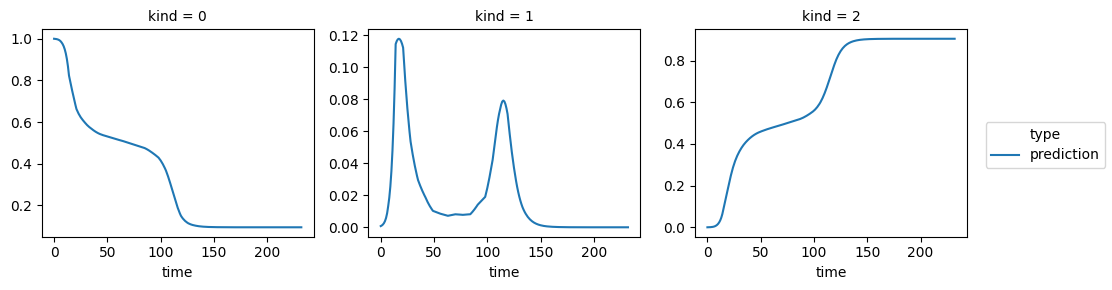

In [367]:
predicted_data = [torch.tensor([0.9999, 0.0005, 0])]
for t in range(training_data.shape[0]):
    
    predicted_parameters = NN(training_data[t]).detach()
    beta = torch.clamp((
            0.0024*weathermob_data[t, 0]**3 - (0.0005*weathermob_data[t, 1]*weathermob_data[t, 0]**3))
        ,0.001)
    print(beta[0])
    #beta = predicted_parameters[0] + weathermob_data[t, 0]*predicted_parameters[1]
    predicted_data.append(SIR_model(predicted_data[t], 
                                    parameters={'k_I': beta[0], 
                                                'k_R': 0.2, 'dt': torch.tensor(1)}))
xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}).plot(col="kind", hue='type', sharey=False)

In [394]:
training_data[0]

tensor([9.9998e-01, 3.3570e-06, 2.2380e-06])

0.0 0
8.359410289326325e-05 0
8.359410289326325e-05 0
0.0001671882057865265 0
0.0001671882057865265 0
0.004744914480095001 0
0.004744914480095001 0
0.009322640754403477 0
0.009322640754403477 0
0.013900367028711953 0
0.013900367028711953 0
0.03433155662964071 0
0.03433155662964071 0
0.028804859703994802 0
0.028804859703994802 0
0.04370935237927765 0
0.04370935237927765 0
0.041221780571048916 0
0.041221780571048916 0
0.05363870143810302 0
0.05363870143810302 0
0.06605562230515713 0
0.06605562230515713 0
0.07847254317221124 0
0.07847254317221124 0
0.10330638490631947 0
0.10330638490631947 0
0.12814022664042768 0
0.12814022664042768 0
0.1529740683745359 0
0.1529740683745359 0
0.1778079101086441 0
0.1778079101086441 0
0.20264175184275232 0
0.20264175184275232 0
0.2923237879636847 0
0.2923237879636847 0
0.38200582408461703 0
0.38200582408461703 0
0.4716878602055494 0
0.4716878602055494 0
0.5613698963264818 0
0.5613698963264818 0
0.6510519324474142 0
0.6510519324474142 0
0.7407339685683466 0

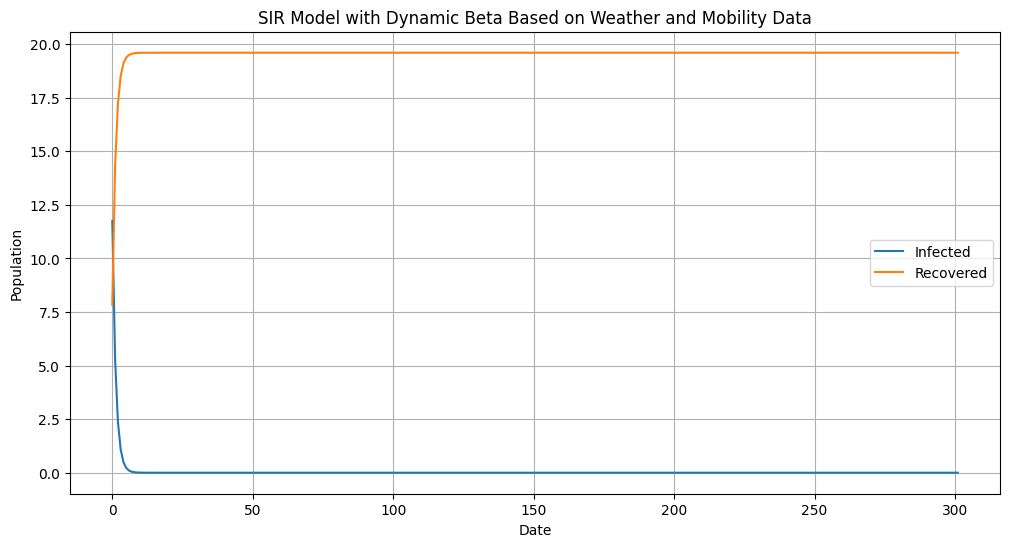

In [415]:
# Define parameters for beta calculation
par1 = 0.5963  # Parameter 1 for beta calculation (adjustable)
par2 = 0.9230  # Parameter 2 for beta calculation (adjustable)

# Total population, N
N = 3500000
# Initial number of infected and recovered individuals, I0 and R0
I0, R0 = 3.3570e-06*N, 2.2380e-06*N
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Function to calculate beta based on outOfHomeDuration and outdoorFraction
def calculate_beta(out_of_home_duration, outdoor_fraction, par1, par2):
    # Calculate beta using given parameters and formula
    beta = (par1 * out_of_home_duration**1.0796- par2 * outdoor_fraction * out_of_home_duration**1.0796)
    return max(beta, 0.001)  # Apply a minimum constraint to avoid negative or zero values

# The SIR model differential equations
def sir_model(y, t, N, par1, par2, df):
    S, I, R = y
    # Find the closest matching index for the current time 't'
    current_index = int(min(t, len(df) - 1))
    current_data = df.iloc[current_index]
    # Calculate beta using current values of outOfHomeDuration and outdoorFraction
    beta = calculate_beta(current_data['outOfHomeDuration'], current_data['outdoorFraction'], par1, par2)
    print(t, current_index)
    gamma = 0.8  # Recovery rate, assumed constant

    # SIR model equations
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Time grid corresponding to the length of the data
t = np.arange(len(weathermob_df))

# Integrate the SIR equations over the time grid, t
result = odeint(sir_model, y0, t, args=(N, par1, par2, weathermob_df))

# Extract the results
S, I, R = result.T

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('SIR Model with Dynamic Beta Based on Weather and Mobility Data')
plt.legend()
plt.grid()
plt.show()

In [411]:
t 

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.4402047999999999
0.4402047999999999
0.4402047999999999
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.4402047999999999
0.4402047999999999
0.4402047999999999
0.44020479999999

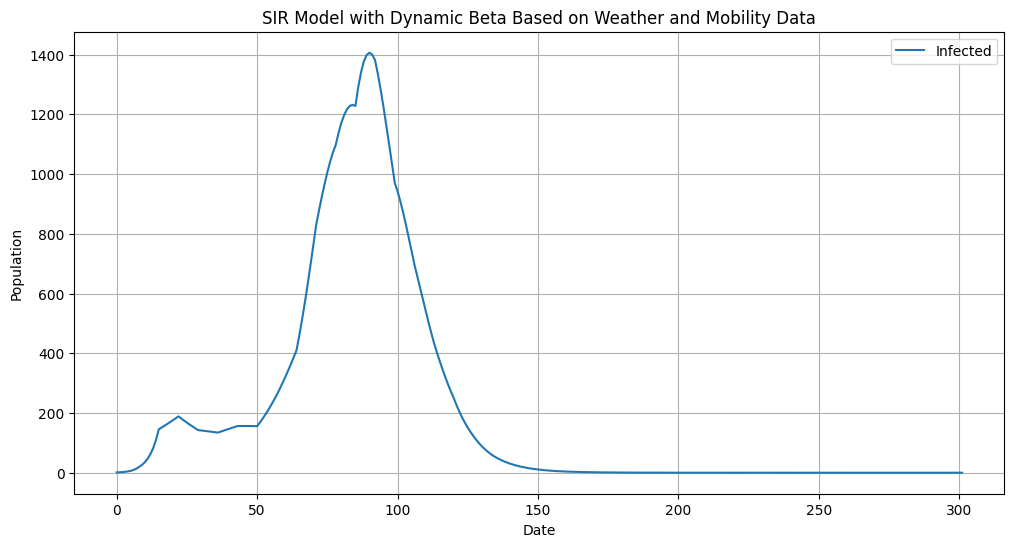

In [431]:
# Define parameters for beta calculation
par1 = 0.0024  # Parameter 1 for beta calculation (adjustable)
par2 = 0.0005  # Parameter 2 for beta calculation (adjustable)

# Total population, N
N = 10000
# Initial number of infected and recovered individuals, I0 and R0
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Function to calculate beta based on outOfHomeDuration and outdoorFraction
def calculate_beta(out_of_home_duration, outdoor_fraction, par1, par2):
    # Calculate beta using given parameters and formula
    beta = par1 * out_of_home_duration**3- par2 * outdoor_fraction * out_of_home_duration**3
    return max(beta, 0.001)  # Apply a minimum constraint to avoid negative or zero values

# The SIR model differential equations
def sir_model(y, t, N, par1, par2, df):
    S, I, R = y
    # Find the closest matching index for the current time 't'
    current_index = int(min(t, len(df) - 1))
    current_data = df.iloc[current_index]
    # Calculate beta using current values of outOfHomeDuration and outdoorFraction
    beta = calculate_beta(current_data['outOfHomeDuration'], current_data['outdoorFraction']+1, par1, par2)
    print(beta)
    gamma = 0.15  # Recovery rate, assumed constant

    # SIR model equations
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Time grid corresponding to the length of the data
t = np.arange(len(weathermob_df))

# Integrate the SIR equations over the time grid, t
result = odeint(sir_model, y0, t, args=(N, par1, par2, weathermob_df))

# Extract the results
S, I, R = result.T

# Plot the results
plt.figure(figsize=(12, 6))
#plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
#plt.plot(R, label='Recovered')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('SIR Model with Dynamic Beta Based on Weather and Mobility Data')
plt.legend()
plt.grid()
plt.show()
